## Particle tracking through a transient flow system.

Application of a MODFLOW 6 particle-tracking (PRT) model to solve example 3 from the MODPATH 7 documentation.

### Problem setup

First import dependencies.

In [18]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import MultiPoint, LineString
import flopy
from flopy.utils.gridintersect import GridIntersect
import numpy as np
from pathlib import Path

sys.path.append(os.path.join("..", "common"))
import config
from figspecs import USGSFigure

Setup model name and workspace variables.

In [19]:
ws = config.base_ws
sim_name = "mp7-p03"
example_name = "ex-prt-" + sim_name
sim_ws = Path(ws) / example_name

nm_mf6 = sim_name
nm_prt = sim_name + "_prt"

headfile = f"{sim_name}.hds"
budgetfile = f"{sim_name}.cbb"
budgetfile_prt = f"{nm_prt}.cbb"
pathlinefile_mp7 = f"{sim_name}_mp.mppth"

Define some shared variables, starting with discretization and other flow model data.

In [20]:
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.0
top = 400.0
botm = [220.0, 200.0, 0.0]
laytyp = [1, 0, 0]
kh = [50.0, 0.01, 200.0]
kv = [10.0, 0.01, 20.0]
rchv = 0.005
riv_h = 320.0
riv_z = 317.0
riv_c = 1.0e5

Define well data. Although this notebook will refer to layer/row/column indices starting at 1, indices in FloPy (and more generally in Python) are zero-based. A negative discharge indicates pumping, while a positive value indicates injection.

In [21]:
wells = [
    # layer, row, col, discharge
    (0, 10, 9, -75000),
    (2, 12, 4, -100000),
]

Define the drain location.

In [22]:
drain = (0, 14, (9, 20))

Configure locations for particle tracking to terminate. We have three explicitly defined termination zones:

- 2: the well in layer 1, at row 11, column 10
- 3: the well in layer 3, at row 13, column 5
- 4: the drain in layer 1, running through row 15 from column 10-20

MODFLOW 6 reserves zone number 1 to indicate that particles may move freely within the zone.

The river running through column 20 is also a termination zone, but it doesn't need to be defined separately since we are using the RIV package.

In [23]:
zone_maps = []

# zone 1 is the default (non-terminating regions)
def fill_zone_1():
    return np.ones((nrow, ncol), dtype=np.int32)

# zone map for layer 1
za = fill_zone_1()
za[wells[0][1:3]] = 2
za[drain[1], drain[2][0] : drain[2][1]] = 4
zone_maps.append(za)

# constant layer 2 (zone 1)
zone_maps.append(1)

# zone map for layer 3
za = fill_zone_1()
za[wells[1][1:3]] = 3
zone_maps.append(za)

Define particles to track. Particles are released from the top of a 2x2 square of cells in the upper left of the midel grid's top layer.

In [24]:
rel_minl = rel_maxl = 0
rel_minr = 2
rel_maxr = 3
rel_minc = 2
rel_maxc = 3
sd = flopy.modpath.CellDataType(
    drape=0
)  # particles added at top of cell (no drape)
lrcregions = [[[rel_minl, rel_minr, rel_minc, rel_maxl, rel_maxr, rel_maxc]]]
pd = flopy.modpath.LRCParticleData(
    subdivisiondata=[sd],
    lrcregions=lrcregions,
)
pg = flopy.modpath.ParticleGroupLRCTemplate(
    particlegroupname="PG1", particledata=pd, filename=f"{sim_name}.pg1.sloc"
)
pgs = [pg, pg, pg, pg, pg, pg, pg, pg, pg, pg]
defaultiface = {"RECHARGE": 6, "ET": 6}

Define functions to convert the MODPATH 7 particle data to the representation PRT expects.

In [25]:
from flopy.modpath.mp7particledata import FaceDataType, CellDataType

from itertools import product
from pprint import pprint

def get_cell_particles(subdivisiondata, grid, k=None, i=None, j=None, nn=None):
    cell_particles = []

    # get cell coords and span in each dimension
    if not (k is None or i is None or j is None):
        verts = grid.get_cell_vertices(i, j)
        minz, maxz = grid.botm[k, i, j], grid.top[i, j]
    elif nn is not None:
        verts = grid.get_cell_vertices(nn)
        if grid.grid_type == "structured":
            k, i, j = grid.get_lrc([nn])[0]
            minz, maxz = grid.botm[k, i, j], grid.top[i, j]
        else:
            minz, maxz = grid.botm[nn], grid.top[nn]
    else:
        raise ValueError(
            f"A cell (node) must be specified by indices (for structured grids) or node number (for vertex/unstructured)"
        )
    xs, ys = list(zip(*verts))
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    xspan = maxx - minx
    yspan = maxy - miny
    zspan = maxz - minz

    if isinstance(subdivisiondata, FaceDataType):
        # face perpendicular to x (outer)
        if (
            subdivisiondata.verticaldivisions1 > 0
            and subdivisiondata.horizontaldivisions1 > 0
        ):
            yincr = yspan / subdivisiondata.horizontaldivisions1
            ylocs = [
                (miny + (yincr * 0.5) + (yincr * d))
                for d in range(subdivisiondata.horizontaldivisions1)
            ]
            zincr = zspan / subdivisiondata.verticaldivisions1
            zlocs = [
                (minz + (zincr * 0.5) + (zincr * d))
                for d in range(subdivisiondata.verticaldivisions1)
            ]
            prod = list(product(*[ylocs, zlocs]))
            cell_particles = cell_particles + [
                (minx, p[0], p[1]) for p in prod
            ]

        # face perpendicular to x (outer)
        if (
            subdivisiondata.verticaldivisions2 > 0
            and subdivisiondata.horizontaldivisions2 > 0
        ):
            yincr = yspan / subdivisiondata.horizontaldivisions2
            ylocs = [
                (miny + (yincr * 0.5) + (yincr * d))
                for d in range(subdivisiondata.horizontaldivisions2)
            ]
            zincr = zspan / subdivisiondata.verticaldivisions2
            zlocs = [
                (minz + (zincr * 0.5) + (zincr * d))
                for d in range(subdivisiondata.verticaldivisions2)
            ]
            prod = list(product(*[ylocs, zlocs]))
            cell_particles = cell_particles + [
                (maxx, p[0], p[1]) for p in prod
            ]

        # face perpendicular to y (inner)
        if (
            subdivisiondata.verticaldivisions3 > 0
            and subdivisiondata.horizontaldivisions3 > 0
        ):
            xincr = xspan / subdivisiondata.horizontaldivisions3
            xlocs = [
                (minx + (xincr * 0.5) + (xincr * rd))
                for rd in range(subdivisiondata.horizontaldivisions3)
            ]
            zincr = zspan / subdivisiondata.verticaldivisions3
            zlocs = [
                (minz + (zincr * 0.5) + (zincr * d))
                for d in range(subdivisiondata.verticaldivisions3)
            ]
            prod = list(product(*[xlocs, zlocs]))
            cell_particles = cell_particles + [
                (p[0], miny, p[1]) for p in prod
            ]

        # face perpendicular to y (outer)
        if (
            subdivisiondata.verticaldivisions4 > 0
            and subdivisiondata.horizontaldivisions4 > 0
        ):
            xincr = xspan / subdivisiondata.horizontaldivisions4
            xlocs = [
                (minx + (xincr * 0.5) + (xincr * rd))
                for rd in range(subdivisiondata.horizontaldivisions4)
            ]
            zincr = zspan / subdivisiondata.verticaldivisions4
            zlocs = [
                (minz + (zincr * 0.5) + (zincr * d))
                for d in range(subdivisiondata.verticaldivisions4)
            ]
            prod = list(product(*[xlocs, zlocs]))
            cell_particles = cell_particles + [
                (p[0], maxy, p[1]) for p in prod
            ]

        # bottom face
        if (
            subdivisiondata.rowdivisions5 > 0
            and subdivisiondata.columndivisions5 > 0
        ):
            xincr = xspan / subdivisiondata.columndivisions5
            xlocs = [
                (minx + (xincr * 0.5) + (xincr * rd))
                for rd in range(subdivisiondata.columndivisions5)
            ]
            yincr = yspan / subdivisiondata.rowdivisions5
            ylocs = [
                (miny + (yincr * 0.5) + (yincr * rd))
                for rd in range(subdivisiondata.rowdivisions5)
            ]
            prod = list(product(*[xlocs, ylocs]))
            cell_particles = cell_particles + [
                (p[0], p[1], minz) for p in prod
            ]

        # top face
        if (
            subdivisiondata.rowdivisions6 > 0
            and subdivisiondata.columndivisions6 > 0
        ):
            xincr = xspan / subdivisiondata.columndivisions6
            xlocs = [
                (minx + (xincr * 0.5) + (xincr * rd))
                for rd in range(subdivisiondata.columndivisions6)
            ]
            yincr = yspan / subdivisiondata.rowdivisions5
            ylocs = [
                (miny + (yincr * 0.5) + (yincr * rd))
                for rd in range(subdivisiondata.rowdivisions6)
            ]
            prod = list(product(*[xlocs, ylocs]))
            cell_particles = cell_particles + [
                (p[0], p[1], maxz) for p in prod
            ]
    elif isinstance(subdivisiondata, CellDataType):
        xincr = xspan / subdivisiondata.columncelldivisions
        xlocs = [
            (minx + (xincr * 0.5) + (xincr * rd))
            for rd in range(subdivisiondata.columncelldivisions)
        ]
        yincr = yspan / subdivisiondata.rowcelldivisions
        ylocs = [
            (miny + (yincr * 0.5) + (yincr * d))
            for d in range(subdivisiondata.rowcelldivisions)
        ]
        zincr = zspan / subdivisiondata.layercelldivisions
        zlocs = [
            (minz + (zincr * 0.5) + (zincr * d))
            for d in range(subdivisiondata.layercelldivisions)
        ]
        prod = list(product(*[xlocs, ylocs, zlocs]))
        cell_particles = cell_particles + prod
    else:
        raise ValueError(
            f"Unsupported subdivision data type: {type(subdivisiondata)}"
        )

    return cell_particles

def to_coords(grid, lrcregions, subdivisiondata):
    """
    Convert the particle representation to a list of global coordinates.
    Parameters
    ----------
    grid : The grid to use for locating particle coordinates
    Returns
    -------
        A list of particle tuples (particle ID, x coord, y coord, z coord)
    """

    if grid.grid_type != "structured":
        raise ValueError(
            f"Particle representation is structured but grid is not"
        )

    particles = []
    for region in lrcregions[0]:
        mink, mini, minj, maxk, maxi, maxj = region
        for k in range(mink, maxk + 1):
            for i in range(mini, maxi + 1):
                for j in range(minj, maxj + 1):
                    for sd in subdivisiondata:
                        particles = particles + get_cell_particles(
                            sd, grid, k, i, j
                        )

    return particles

Define a function to create the MODFLOW 6 simulation, which will include a groundwater flow (GWF) model and a particle tracking (PRT) model.

In [26]:
def build_mf6_model():
    print("Building MODFLOW 6 model")

    # simulation
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name, exe_name=config.mf6_exe, version="mf6", sim_ws=sim_ws
    )

    # temporal discretization
    tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
        sim,
        pname="tdis",
        time_units="DAYS",
        nper=4,
        perioddata=[
            # perlen, nstp, tsmult
            (90000, 1, 1),
            (10000, 500, 1),
            (36500, 10, 1),
            (100000, 1, 1),
        ]
    )

    # groundwater flow (gwf) model
    model_nam_file = f"{sim_name}.nam"
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=sim_name, model_nam_file=model_nam_file, save_flows=True
    )

    # iterative model solver (ims) package
    ims = flopy.mf6.modflow.mfims.ModflowIms(
        sim,
        pname="ims",
        complexity="SIMPLE",
        outer_dvclose=1e-6,
        inner_dvclose=1e-6,
        rcloserecord=1e-6,
    )

    # grid discretization
    dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        gwf,
        pname="dis",
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        length_units="FEET",
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )

    # initial conditions
    ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=top)

    # node property flow
    npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
        gwf, pname="npf", icelltype=laytyp, k=kh, k33=kv, save_flows=True, save_specific_discharge=True, save_saturation=True
    )

    # recharge
    rch = flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(gwf, recharge=rchv)

    # wells
    def no_flow(w):
        return w[0], w[1], w[2], 0

    nf_wells = [no_flow(w) for w in wells] 
    wel = flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
        gwf,
        maxbound=1,
        stress_period_data={0: nf_wells, 1: nf_wells, 2: wells, 3: wells},
    )

    # river
    rd = [[(0, i, ncol - 1), riv_h, riv_c, riv_z] for i in range(nrow)]
    flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(
        gwf, stress_period_data={0: rd}
    )

    # drain (set auxiliary IFACE var to 6 for top of cell)
    dd = [
        [drain[0], drain[1], i + drain[2][0], 322.5, 100000.0, 6]
        for i in range(drain[2][1] - drain[2][0])
    ]
    drn = flopy.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf, stress_period_data={0: dd})

    # output control
    oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
        gwf,
        pname="oc",
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        head_filerecord=[headfile],
        budget_filerecord=[budgetfile],
    )

    # Instantiate the MODFLOW 6 prt model
    prt = flopy.mf6.ModflowPrt(
        sim, modelname=nm_prt, model_nam_file="{}.nam".format(nm_prt)
    )

    # Instantiate the MODFLOW 6 prt discretization package
    flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        prt, pname="dis",
        nlay=nlay, nrow=nrow, ncol=ncol,
        length_units="FEET",
        delr=delr, delc=delc,
        top=top, botm=botm,
    )

    # Instantiate the MODFLOW 6 prt model input package
    porosity = 0.1
    flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity)

    def to_release_pt(pid, coord):
        k, i, j = gwf.modelgrid.intersect(coord[0], coord[1], coord[2])
        return pid, k, i, j, coord[0], coord[1], coord[2]

    # Instantiate the MODFLOW 6 prt particle release point (prp) package
    coords = to_coords(gwf.modelgrid, lrcregions, [sd])
    releasepts = [to_release_pt(i, c) for i, c in enumerate(coords)]
    flopy.mf6.ModflowPrtprp(
        prt, pname="prp1", filename="{}_1.prp".format(nm_prt),
        nreleasepts=len(releasepts), packagedata=releasepts,
        perioddata={
            0: [],
            # 1: ["STEPS"] + [str(i + 1) for i in range(4500, 4510)],
            1: ["STEPS"] + [str(i + 1) for i in range(10)],
            2: [],
            3: [],
            # 4: []
        },
    )

    # Instantiate the MODFLOW 6 prt output control package
    flopy.mf6.ModflowPrtoc(
        prt,
        pname="oc",
        budget_filerecord=[budgetfile_prt],
        saverecord=[("BUDGET", "ALL")],
    )

    # Instantiate the MODFLOW 6 prt flow model interface
    flopy.mf6.ModflowPrtfmi(prt, packagedata=[
        ("GWFHEAD", headfile),
        ("GWFBUDGET", budgetfile)
    ])

    # Create the MODFLOW 6 gwf-prt model exchange
    flopy.mf6.ModflowGwfprt(
        sim, exgtype="GWF6-PRT6",
        exgmnamea=nm_mf6, exgmnameb=nm_prt,
        filename="{}.gwfprt".format(nm_mf6),
    )

    # Create an explicit model solution (EMS) for the MODFLOW 6 prt model
    ems = flopy.mf6.ModflowEms(
        sim, pname="ems",
        filename=f"{nm_prt}.ems",
    )
    sim.register_solution_package(ems, [prt.name])

    return sim

Define a function create the MODPATH 7 model & simulation.

In [27]:
def build_mp7_model(gwf):
    print("Building MODPATH 7 model...")

    mp = flopy.modpath.Modpath7(
        modelname=f"{sim_name}_mp",
        flowmodel=gwf,
        exe_name="mp7",
        model_ws=sim_ws,
    )
    mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1, defaultiface=defaultiface)
    mpsim = flopy.modpath.Modpath7Sim(
        mp,
        simulationtype="combined",
        trackingdirection="forward",
        weaksinkoption="pass_through",
        weaksourceoption="pass_through",
        budgetoutputoption="summary",
        referencetime=[1, 0, 0.0], # start when 2nd stress period begins
        timepointdata=[10, 20.0],  # release every 20 days for 200 days
        zonedataoption="on",
        zones=zone_maps,
        particlegroups=pgs,
    )

    return mp

Define a function to build both simulations.

In [28]:
def build_models():
    mf6sim = build_mf6_model()
    gwf = mf6sim.get_model(nm_mf6)
    mp7sim = build_mp7_model(gwf)
    return mf6sim, mp7sim

Define a function to run the MODFLOW 6 and MOPATH 7 models/simulations.

In [29]:
def run_models(mf6sim, mp7sim):
    mf6sim.write_simulation()
    success, buff = mf6sim.run_simulation(silent=True, report=True)
    for line in buff:
        print(line)
    assert success, "Failed to run MODFLOW 6"

    mp7sim.write_input()
    success, buff = mp7sim.run_model(silent=True, report=True)
    for line in buff:
        print(line)
    assert success, "Failed to run MODPATH 7"

Define functions to load pathline data from the budget file created by the PRT model.

In [30]:
def load_mf6_pathlines(cbb, prpnam=None):

    ncpl = nrow * ncol
    dtype={'names':['x','y','z','time','k','particleid'],
           'formats':['<f4','<f4','<f4','<f4','<i4','<i4'],
          }
    # upn = cbb.get_unique_package_names(decode=True)
    times = cbb.get_times()

    # Extract pathline data to a dictionary keyed on capture destination (well or river)
    mf6pathlines = {}
    # for prpnam in upn:
    pdict = {}
    # For each time, read and parse particle data written by the prp
    # and add it to a dictionary keyed on a particle identifier consisting
    # of release point number and release time
    for totim in times:
        data = cbb.get_data(text='DATA-PRTCL', paknam=prpnam, totim=totim)
        for ploc in data[0]:
            # Particle data read from the binary output file are in terms
            # of one-based indexing; will convert to zero-based indexing
            irpt, node, xp, yp, zp, trelease, ttrack = [ploc[i] for i in (0, 1, 3, 4, 5, 6, 7)]
            irpt -= 1
            node -= 1
            kp = node // ncpl
            # issue(mf6): particle ids not assigned yet in mf6
            pathpoint = (xp, yp, zp, ttrack, kp, 0)
            key = (irpt, trelease)
            # Note that repeat locations written for terminated particles
            # are not filtered out here, though they could be
            if key not in pdict:
                pdict[key] = [pathpoint]
            else:
                pdict[key].append(pathpoint)

    # Sort the dictionary into separate dictionaries of formatted arrays
    # for pathlines ending at the well, the drain, and the river
    mf6pathlines['well'] = []
    mf6pathlines['river'] = []
    mf6pathlines['drain'] = []
    for key in pdict:
        path = np.core.records.fromarrays(np.array(pdict[key]).T, dtype=dtype)
        # issue(mf6): zone info not stored with particle locations, so using
        #   x coordinate to determine capture/endpoint zone in this problem.
        x = path['x'][-1]
        capture_zone = "river" if x > 5500 else "well"
        mf6pathlines[capture_zone].append(path)
                    
    # Return mf6pathlines
    return mf6pathlines

Define a function to load pathline data from the MODPATH 7 models' output files.

In [31]:
def load_mp7_pathlines(pth, grid):
    wel_locs = [w[0:3] for w in wells]
    riv_locs = [(0, i, 19) for i in range(20)]
    drn_locs = [(drain[0], drain[1], d) for d in range(drain[2][0], drain[2][1])]
    wel_nids = grid.get_node(wel_locs)
    riv_nids = grid.get_node(riv_locs)
    drn_nids = grid.get_node(drn_locs)

    mp7pathlines = {}
    p = flopy.utils.PathlineFile(pth)
    mp7pathlines["well"] = p.get_destination_pathline_data(wel_nids, to_recarray=True)
    mp7pathlines["river"] = p.get_destination_pathline_data(riv_nids + drn_nids, to_recarray=True)

    return mp7pathlines

Define functions to plot the heads and pathline results, with pathlines colored by capture zone.

In [32]:
def plot_pathlines(ax, gwf, hd, pl, title):
    ax.set_aspect("equal")
    ax.set_title(title)
    mv = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mv.plot_grid(lw=0.5)
    mv.plot_bc("DRN")
    mv.plot_bc("RIV")
    mv.plot_bc("WEL", plotAll=True)
    hd = mv.plot_array(hd, alpha=0.2)
    cb = plt.colorbar(hd, shrink=0.5, ax=ax)
    cb.set_label("Head")
    mv.plot_pathline(
        pl['well'],
        layer="all",
        colors=["red"],
        label="captured by well",
    )
    mv.plot_pathline(
        pl['river'],
        layer="all",
        colors=["blue"],
        label="captured by drain/river",
    )
    mv.ax.legend()

def plot_pathlines_xc(ax, gwf, hd, pl, title):
    # ax.set_aspect("equal")
    ax.set_title(title)
    mv = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 12})
    mv.plot_grid(lw=0.5)
    mv.plot_bc("DRN")
    mv.plot_bc("RIV")
    mv.plot_bc("WEL")
    hd = mv.plot_array(hd, alpha=0.2)
    cb = plt.colorbar(hd, shrink=0.5, ax=ax)
    cb.set_label("Head")
    mv.plot_pathline(
        pl['well'],
        colors=["red"],
        label="captured by well",
    )
    mv.plot_pathline(
        pl['river'],
        colors=["blue"],
        label="captured by drain/river",
    )
    mv.ax.legend()

def plot_results(gwf, heads, mf6pl, mp7pl):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14, 14))
    plt.suptitle(
        t="Example 3: Structured transient forward-tracking model with multiple release times",
        fontsize=14,
        y=1.1,
    )

    plot_pathlines(axes[0][0], gwf, heads, mf6pl, "MODFLOW 6 PRT map view")
    plot_pathlines(axes[0][1], gwf, heads, mp7pl, "MODPATH 7 map view")
    plot_pathlines_xc(axes[1][0], gwf, heads, mf6pl, "MODFLOW 6 PRT cross section")
    plot_pathlines_xc(axes[1][1], gwf, heads, mp7pl, "MODPATH 7 cross section")
    
    plt.show()

Define a function to wrap the entire scenario.

In [33]:
import flopy.utils.binaryfile as bf

def scenario():
    # build models
    mf6sim, mp7sim = build_models()
    gwf = mf6sim.get_model(nm_mf6)
    grid = gwf.modelgrid

    # run models
    run_models(mf6sim, mp7sim)

    # load results
    hds = flopy.utils.HeadFile(sim_ws / headfile).get_data()
    cbb = bf.CellBudgetFile(sim_ws / budgetfile_prt)
    mf6_pl = load_mf6_pathlines(cbb)
    mp7_pl = load_mp7_pathlines(sim_ws / pathlinefile_mp7, grid)

    # plot results
    plot_results(gwf, hds, mf6_pl, mp7_pl)

Run the MODPATH 7 example problem 3 scenario.

Building MODFLOW 6 model
Building MODPATH 7 model...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing solution package ems...
  writing package mp7-p03.gwfprt...
  writing model mp7-p03...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 11 based on size of stress_period_data
    writing package oc...
  writing model mp7-p03_prt...
    writing model name file...
    writing package dis...
    writing package mip...
    writing package prp1...
    writing

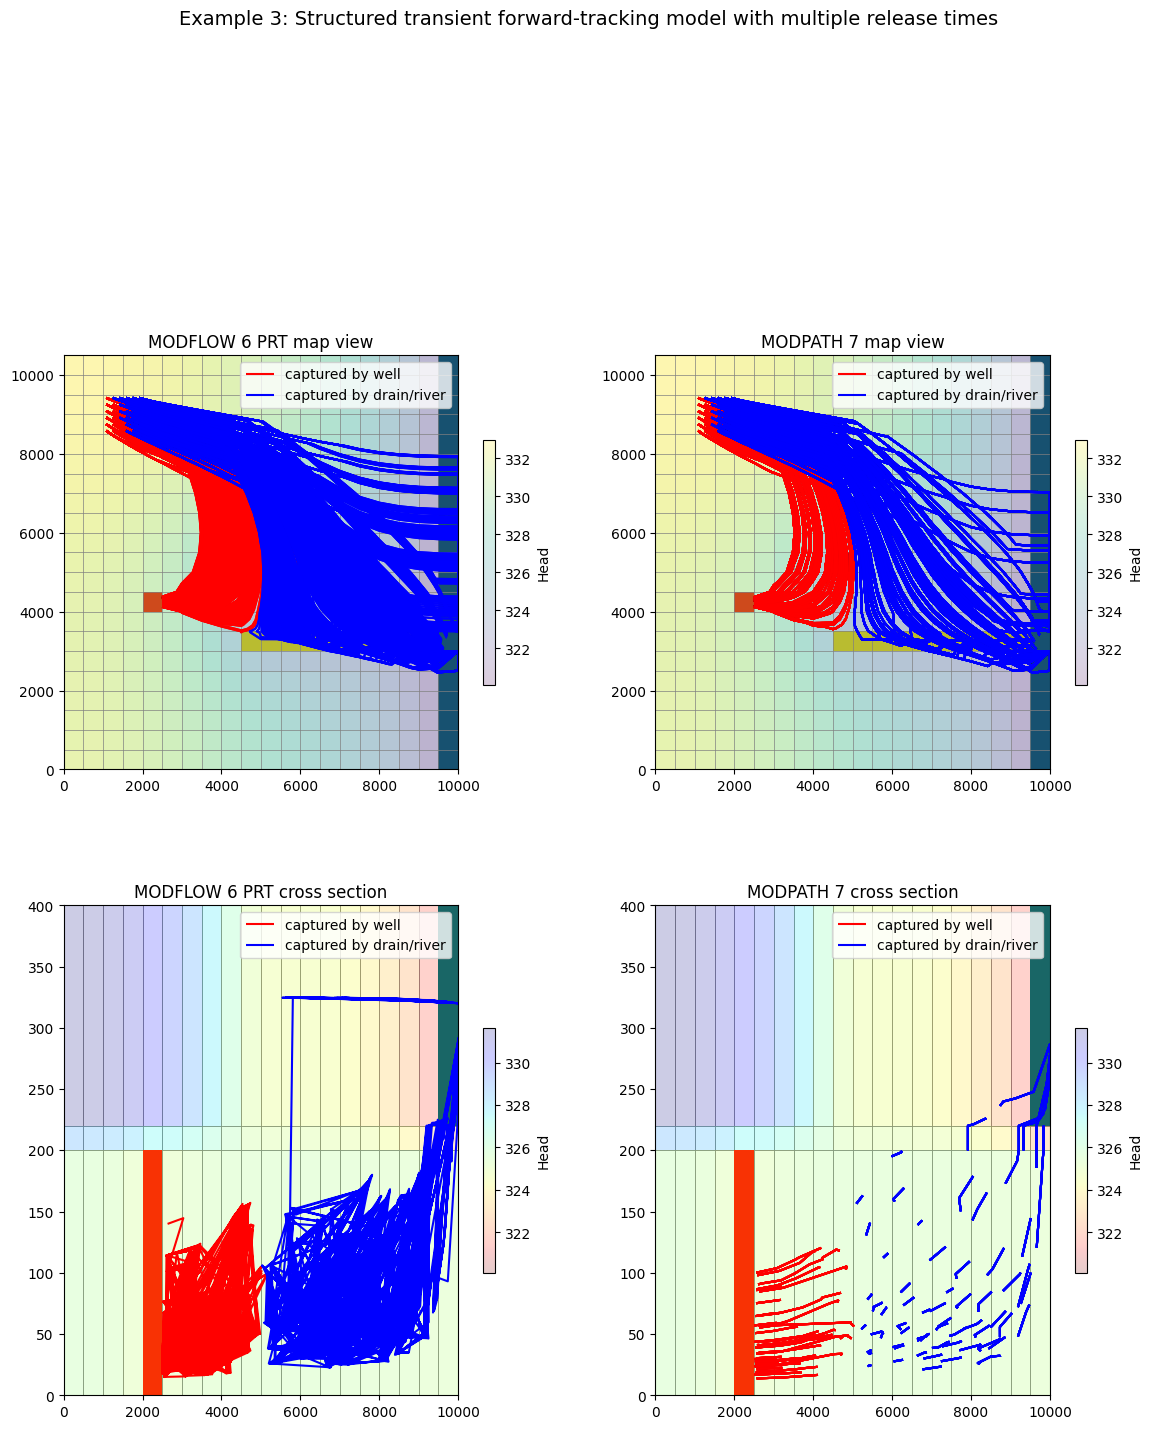

In [34]:
scenario()